In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [3]:
from neuron import h
h.load_file("stdrun.hoc");

In [4]:
from glob import glob
cellhocs = sorted(glob('Cell_*.hoc'))
cellhoc = cellhocs[0]
cellhoc

'Cell_1.hoc'

In [5]:
nsweeps = 7
rates = np.linspace(0., 30., nsweeps)
simtime = 200 #500
tottime = simtime * nsweeps

In [6]:
def breadth(sec):
    return len(sec.subtree())

def is_terminal(sec):
    return breadth(sec) == 1

def is_stem(sec):
    return 'soma' in str(sec.parentseg()) and not 'soma' in sec.name()

def get_terminals(sec):
    return [s for s in sec.subtree() if is_terminal(s)]

def get_stems(sec):
    return [s for s in sec.wholetree() if is_stem(s)]

In [7]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [8]:
def make_cell(hoc, morph=None):
    h.load_file(hoc)
    name = hoc.split('.')[0]
    if morph:
        cmd = f'h.{name}("../morphology/", "{morph}")'
    else:
        cmd = f'h.{name}("../morphology/")'  # default morphology
    cell = eval(cmd)
    return cell

In [9]:
def make_nterm_cells(hoc, morph=None):
    cell = make_cell(hoc, morph)
    nterm = len([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
    cells = [make_cell(hoc, morph) for i in range(nterm)]
    return cells

In [10]:
cells = make_nterm_cells(cellhoc)
#cells

In [11]:
def set_syn_stim(rates, simtime, cell, seclist=[], nsyn=10, weight=0.5e-3):
    stimuli = []
    nsts = []
    cons = []
    syns = []
    sections = seclist if seclist else np.random.choice(
        [sec for sec in cell.soma[0].subtree() if 'dend' in sec.name()], 10)

    for sec in sections:
        for i, rate in enumerate(rates):
            for x in np.linspace(0., 1., nsyn):
                ns = h.NetStim()
                ns.interval = 1 / rate * 1e3 if rate else 1e9
                ns.noise = 1.0
                ns.start = simtime * i
                ns.number = int(simtime / ns.interval) + 1
                syn = h.tmGlut(sec(x))
                nc = h.NetCon(ns, syn)
                nc.weight[0] = weight
                cons.append(nc)
                syns.append(syn)
                nsts.append(ns)
                stimuli.append((cons, syns, nsts))
    
    return stimuli

In [12]:
def set_term_syn(rates, simtime, cells, nsyn=10, weight=0.5e-3):
    synstimuli = []
    for i, cell in enumerate(cells):
        dend_terms = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        term = dend_terms[i]
        stimuli = set_syn_stim(rates, simtime, cell, [term], nsyn, weight)
        synstimuli.append(stimuli)
    return synstimuli

In [13]:
def set_term_stim(amp, cells):
    stimuli = []
    for i, cell in enumerate(cells):
        dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        tip = dend_tips[i]
        stim = h.IClamp(tip(1.0))
        stim.amp = amp
        stim.delay = stim_start
        stim.dur = stim_end - stim_start
        stimuli.append(stim)
    return stimuli

In [14]:
def get_term_volts(cells, x=1.0):
    volts = []
    for i, cell in enumerate(cells):
        dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        volt = h.Vector()
        volt.record(dend_tips[i](x)._ref_v)
        volts.append(volt)
    return volts

In [15]:
def get_soma_volts(cells):
    volts = []
    for i, cell in enumerate(cells):
        volt = h.Vector()
        volt.record(cell.soma[0](0.5)._ref_v)
        volts.append(volt)
    return volts

In [16]:
#synstimuli = set_term_syn(rates, simtime, cells, nsyn=10, weight=0.5e-3 * 4.83/3.13)
synstimuli = set_term_syn(rates, simtime, cells, nsyn=10, weight=0.5e-3 * 4.263/3.118)

In [17]:
volts = get_term_volts(cells, x=0.5)
soma_volts = get_soma_volts(cells)

In [18]:
time = h.Vector()
time.record(h._ref_t)

Vector[29672]

In [19]:
%%time
h.v_init = -100  #-92.5
h.celsius = 35
h.tstop = tottime
cvode = h.CVode()
cvode.active(True)
cvode.atol(cvode.atol() * 10)
h.run()

CPU times: user 1h 53min 16s, sys: 23.4 s, total: 1h 53min 40s
Wall time: 1h 53min 12s


0.0

In [20]:
def get_traces(time, volt, step):
    traces = []
    start = 0.0
    end = start + step
    sel = (time >= start) * (time < end)
    while time[sel].any():
        trace = {}
        trace['T'] = time[sel] - start
        trace['V'] = volt[sel]
        trace['stim_start'] = [0.0]
        trace['stim_end'] = [step]
        if len(trace['T']) > 1:
            traces.append(trace)
        start += step
        end += step
        sel = (time >= start) * (time < end)
    return np.array(traces)

In [21]:
dvolts = []
for volt in volts:
    dtraces = get_traces(np.array(time), np.array(volt), simtime)
    dvolts.append([trace['V'].mean() for trace in dtraces])
dvolts = np.array(dvolts).T

In [22]:
svolts = []
for volt in soma_volts:
    dtraces = get_traces(np.array(time), np.array(volt), simtime)
    svolts.append([trace['V'].mean() for trace in dtraces])
svolts = np.array(svolts).T

In [23]:
ddeps = dvolts - dvolts[0]
sdeps = svolts - svolts[0]

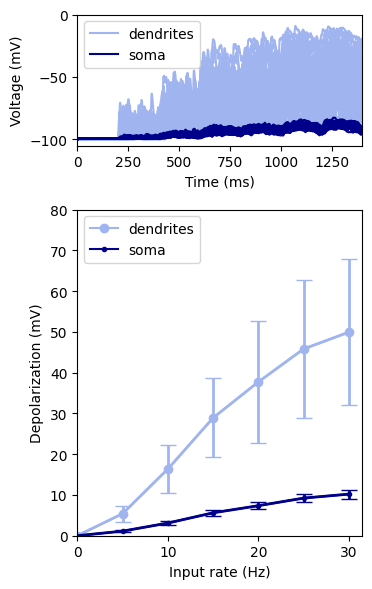

In [24]:
fig = plt.figure(figsize=(4, 6))
gs = fig.add_gridspec(3, 1)

dcolor = lighten_color('royalblue')
scolor = 'darkblue'

ax = fig.add_subplot(gs[:1])

t = np.array(time)

_label = True
for v in volts:
    label = 'dendrites' if _label else ''
    ax.plot(t, v, color=dcolor, label=label)
    _label = False

_label = True
for s in soma_volts:
    label = 'soma' if _label else ''
    ax.plot(t, s, color=scolor, label=label)
    _label = False
    
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage (mV)')
ax.set_xlim(0, tottime)
ax.set_ylim(top=0)
ax.legend()

ax = fig.add_subplot(gs[1:])

ax.plot(rates, [v.mean() for v in ddeps], 'o-', color=dcolor, label='dendrites')
ax.errorbar(rates, [v.mean() for v in ddeps], [v.std() for v in ddeps], 
            color=dcolor, linewidth=2, capsize=6)

ax.plot(rates, [s.mean() for s in sdeps], '.-', color=scolor, label='soma')
ax.errorbar(rates, [s.mean() for s in sdeps], [s.std() for s in sdeps], 
            color=scolor, linewidth=2, capsize=6)

ax.set_ylim(bottom=0)
ax.set_xlim(left=rates[0])
ax.set_ylim(bottom=0, top=80)
ax.set_ylabel('Depolarization (mV)')
ax.set_xlabel('Input rate (Hz)')
ax.legend()

fig.tight_layout()
fig.savefig('images/test6-syn-1.pdf')